<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/od_prophet_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series outlier detection using Prophet on weather data

## Method

The Prophet outlier detector uses the [Prophet](https://facebook.github.io/prophet/) time series forecasting package explained in [this excellent paper](https://peerj.com/preprints/3190/). The underlying Prophet model is a decomposable univariate time series model combining trend, seasonality and holiday effects. The model forecast also includes an uncertainty interval around the estimated trend component using the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated model. Alternatively, full Bayesian inference can be done at the expense of increased compute. The upper and lower values of the uncertainty interval can then be used as outlier thresholds for each point in time. First, the distance from the observed value to the nearest uncertainty boundary (upper or lower) is computed. If the observation is within the boundaries, the outlier score equals the negative distance. As a result, the outlier score is the lowest when the observation equals the model prediction. If the observation is outside of the boundaries, the score equals the distance measure and the observation is flagged as an outlier. One of the main drawbacks of the method however is that you need to refit the model as new data comes in. This is undesirable for applications with high throughput and real-time detection.

To use this detector, first install Prophet by running `pip install alibi-detect[prophet]`.

## Dataset

The example uses a weather time series dataset recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). The dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. Like the [TensorFlow time-series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series), we only use data collected between 2009 and 2016.

In [1]:
!pip install alibi-detect

     |████████████████████████████████| 280 kB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 78.8 MB/s 
     |████████████████████████████████| 4.8 MB 65.0 MB/s 
     |████████████████████████████████| 56 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 88.4 MB/s 
     |████████████████████████████████| 3.3 MB 69.9 MB/s 
     |████████████████████████████████| 895 kB 76.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.14.1
    Uninstalling tensorflow-probability-0.14.1:
      Successfully uninstalled tensorflow-probability-0.14.1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from alibi_detect.od import OutlierProphet
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector

## Load dataset

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
print(df.shape)
df.head()

13582336/13568290 [==============================] - 0s 0us/step
(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Select subset to test Prophet model on:

In [4]:
n_prophet = 10000

Prophet model expects a DataFrame with 2 columns: one named ```ds``` with the timestamps and one named ```y``` with the time series to be evaluated. We will just look at the temperature data:

In [5]:
d = {'ds': df['Date Time'][:n_prophet], 'y': df['T (degC)'][:n_prophet]}
df_T = pd.DataFrame(data=d)
print(df_T.shape)
df_T.head()

(10000, 2)


,ds,y
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27


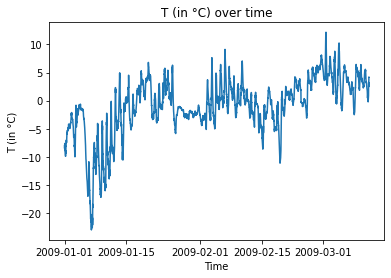

In [6]:
plt.plot(df_T['ds'], df_T['y'])
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

In [7]:
import random
random.seed(128)

In [18]:
df_T['y_corr'] = df_T['y'].apply(lambda x: x + (random.random()-0.5)*20)

In [19]:
df_T

,ds,y,y_corr
0,2009-01-01 00:10:00,-8.02,-17.444497
1,2009-01-01 00:20:00,-8.41,-15.325803
2,2009-01-01 00:30:00,-8.51,-5.750405
3,2009-01-01 00:40:00,-8.31,-13.277772
4,2009-01-01 00:50:00,-8.27,-4.906223
...,...,...,...
9995,2009-03-11 10:00:00,2.69,5.832444
9996,2009-03-11 10:10:00,2.98,12.842702
9997,2009-03-11 10:20:00,3.66,2.405905
9998,2009-03-11 10:30:00,4.21,11.042689


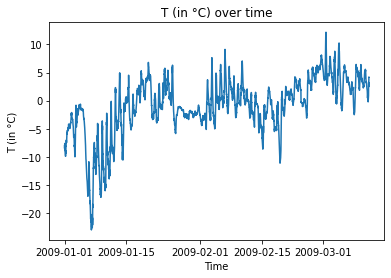

In [21]:
plt.plot(df_T['ds'], df_T['y'])
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

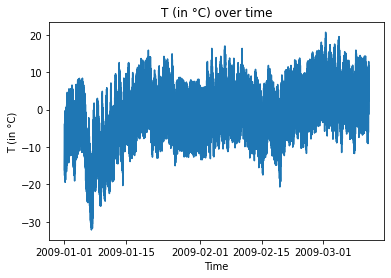

In [22]:
plt.plot(df_T['ds'], df_T['y_corr'])
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

In [27]:
df = pd.DataFrame({'y':df_T['y']})

In [68]:

def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(predict_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, predict_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window)
    train_y = np.asarray(train_y)
    '''
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')
    '''
    predict_x = x[x.shape[0] - window:x.shape[0]]
    predict_x = predict_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout predict_x:", predict_x.shape)

    return train_x, train_y, predict_x


In [111]:
train_x, train_y, predict_x = create_timeseries_dataset(df,df['y'],10,1)

input x: (10000, 1)
input y: (10000,)
outout train_x: (9990, 10)
outout train_y: (9990, 1)
outout predict_x: (1, 10, 1)


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import torch
from torch import nn

from alibi_detect.cd import ClassifierUncertaintyDrift, RegressorUncertaintyDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
from alibi_detect.models.pytorch.trainer import trainer
from alibi_detect.cd.utils import encompass_batching

In [253]:
start_pos = 2000
train_size = 5000

X_train_ds = torch.utils.data.TensorDataset(torch.tensor(train_x[start_pos:start_pos+train_size]).float(), torch.tensor(train_y[start_pos:start_pos+train_size,0]).float())
X_train_dl = torch.utils.data.DataLoader(X_train_ds, batch_size=32, shuffle=False, drop_last=False)

In [254]:
reg = nn.Sequential(
    nn.Linear(10, 60),
    nn.ReLU(),
    nn.Dropout(0.01),
    nn.Linear(60, 20),
    nn.ReLU(),
    #nn.Dropout(0.01),
    nn.Linear(20, 1)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reg.to(device)
trainer(reg, nn.MSELoss(), X_train_dl, device, torch.optim.Adam, learning_rate=0.001, epochs=30)

  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 1/30:  97%|█████████▋| 153/157 [00:00<00:00, 181.62it/s, loss_ma=3.01]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 177.93it/s, loss_ma=1.49]


In [255]:
y_hats = []
for x in train_x[start_pos:]:
    x = torch.tensor(x).float().to(device)
    y_hat = reg(x)
    y_hats.append(y_hat.item())

In [282]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [288]:
A = np.array(df_T['y'][start_pos:])
B = np.array([0,0,0,0,0,0,0,0,0,0]+y_hats)
mse = pd.DataFrame((A-B)**2)

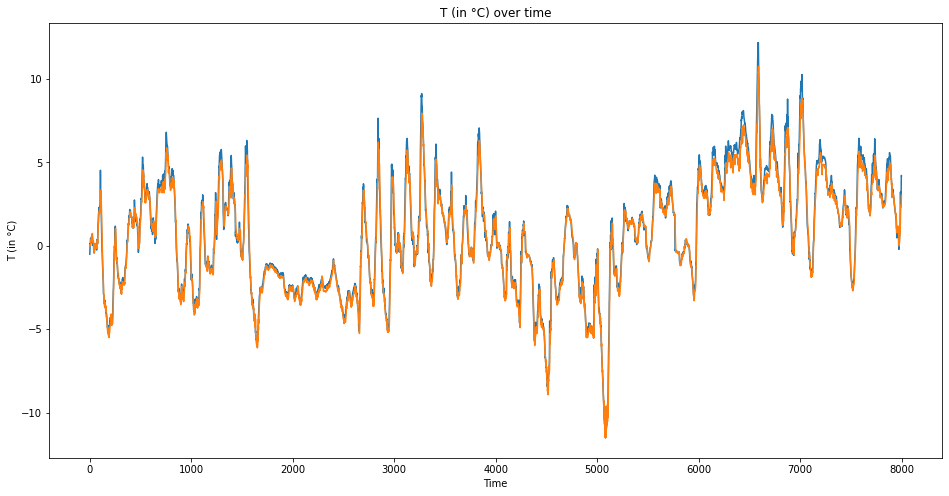

In [257]:
from matplotlib.pyplot import figure

figure(figsize=(16, 8))

plt.plot( list(df_T['y'][start_pos:]))
plt.plot( [0,0,0,0,0,0,0,0,0,0]+y_hats)
#plt.plot(mse)
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

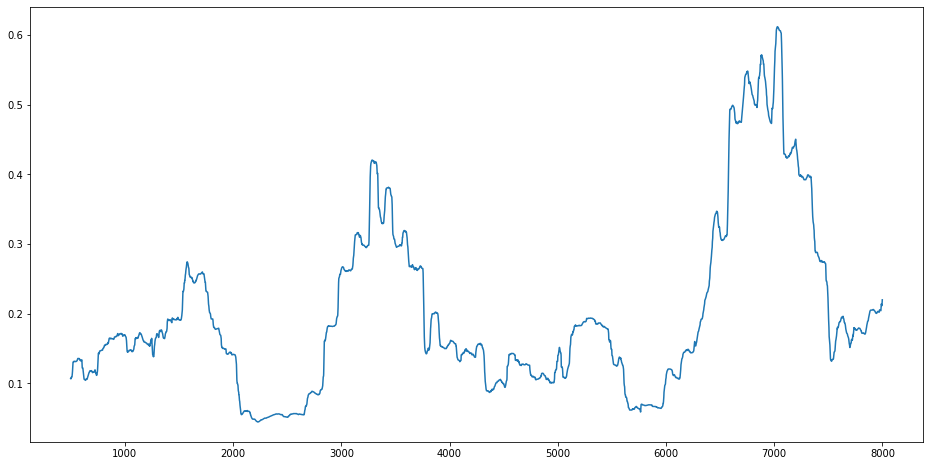

In [294]:
figure(figsize=(16, 8))
plt.plot(mse.rolling(window=500).mean())

In [280]:
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

cd = KSDrift(train_x[start_pos:start_pos+train_size], p_val=0.05)
drift_values = []
for i in range(start_pos,9990):
    x_text = train_x[i:i+2000]
    preds = cd.predict(x_text, drift_type='batch', return_p_val=True, return_distance=True)
    #fpreds = cd.predict(x_text, drift_type='feature')
    #is_drift_count = 0
    d = np.mean(preds['data']['distance'])
    p = np.mean(preds['data']['p_val'])
    #print(i,d,p)
    drift_values.append(d)
    '''
    for f in range(cd.n_features):
        stat = 'K-S'
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        if is_drift:
            pass
        else:
            print(f'{i} {f}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}')   
    '''

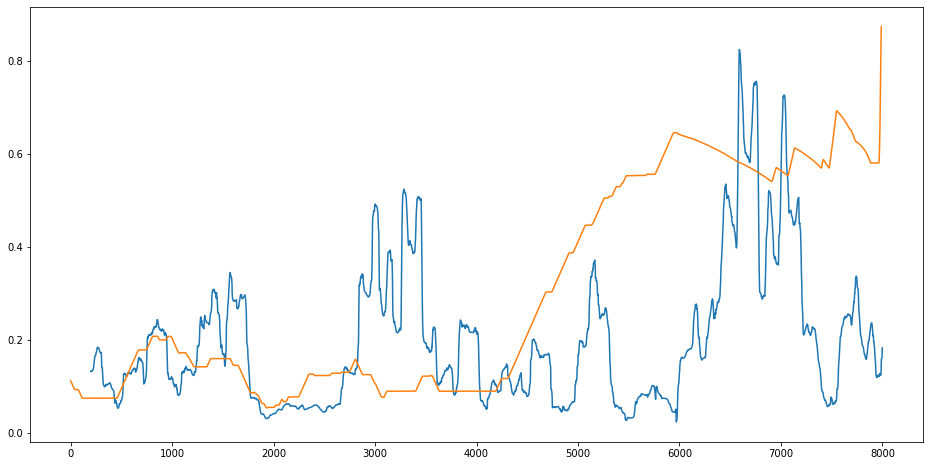

In [302]:
figure(figsize=(16, 8))
plt.plot(mse.rolling(window=200).mean())
plt.plot(np.array(drift_values))

## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [ ]:
load_outlier_detector = False

In [ ]:
filepath = 'my_path'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'weather'
detector_name = 'OutlierProphet'
filepath = os.path.join(filepath, detector_name)    
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # initialize, fit and save outlier detector
    od = OutlierProphet(threshold=.9)
    od.fit(df_T)
    save_detector(od, filepath)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Please check out the [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/prophet.html) as well as the original [Prophet documentation](https://facebook.github.io/prophet/) on how to customize the Prophet-based outlier detector and add seasonalities, holidays, opt for a saturating logistic growth model or apply parameter regularization.

## Predict outliers on test data

Define the test data. It is important that the timestamps of the test data follow the training data. We check this below by comparing the first few rows of the test DataFrame with the last few of the training DataFrame:

In [ ]:
n_periods = 1000
d = {'ds': df['Date Time'][n_prophet:n_prophet+n_periods], 
     'y': df['T (degC)'][n_prophet:n_prophet+n_periods]}
df_T_test = pd.DataFrame(data=d)
df_T_test.head()

,ds,y
10000,2009-03-11 10:50:00,4.12
10001,2009-03-11 11:00:00,4.62
10002,2009-03-11 11:10:00,4.29
10003,2009-03-11 11:20:00,3.95
10004,2009-03-11 11:30:00,3.96


In [ ]:
df_T.tail()

,ds,y
9995,2009-03-11 10:00:00,2.69
9996,2009-03-11 10:10:00,2.98
9997,2009-03-11 10:20:00,3.66
9998,2009-03-11 10:30:00,4.21
9999,2009-03-11 10:40:00,4.19


Predict outliers on test data:

In [ ]:
od_preds = od.predict(
    df_T_test, 
    return_instance_score=True,
    return_forecast=True
)

## Visualize results

We can first visualize our predictions with Prophet's built in plotting functionality. This also allows us to include historical predictions:

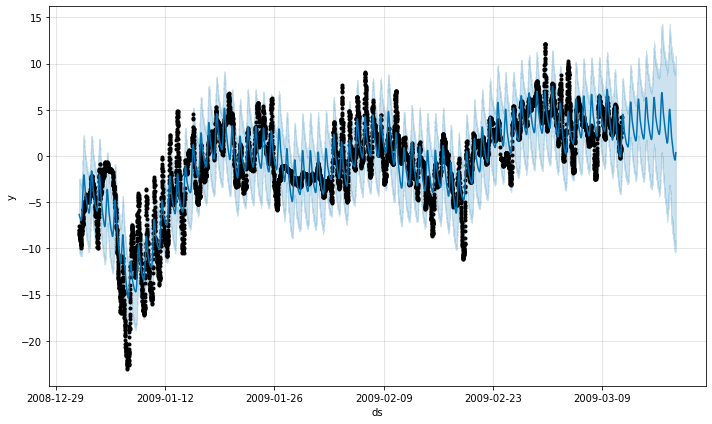

In [ ]:
future = od.model.make_future_dataframe(periods=n_periods, freq='10T', include_history=True)
forecast = od.model.predict(future)
fig = od.model.plot(forecast)

We can also plot the breakdown of the different components in the forecast. Since we did not do full Bayesian inference with `mcmc_samples`, the uncertaintly intervals of the forecast are determined by the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated trend.

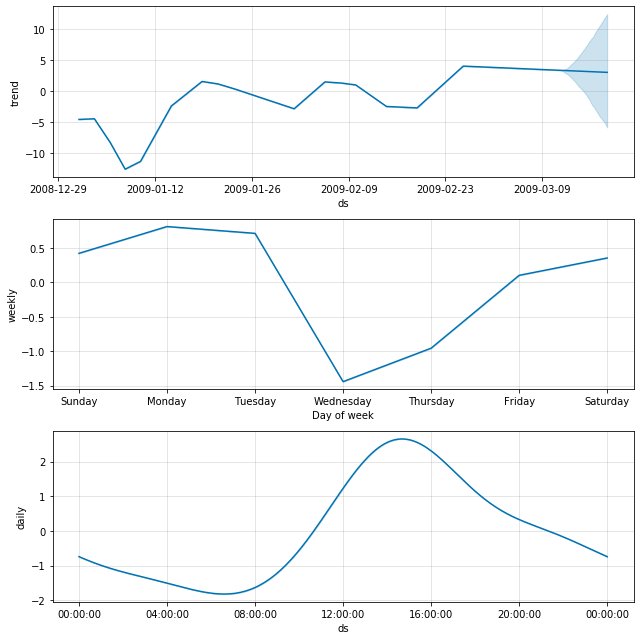

In [ ]:
fig = od.model.plot_components(forecast)

It is clear that the further we predict in the future, the wider the uncertainty intervals which determine the outlier threshold.

Let's overlay the actual data with the upper and lower outlier thresholds predictions and check where we predicted outliers:

In [ ]:
forecast['y'] = df['T (degC)'][:n_prophet+n_periods]

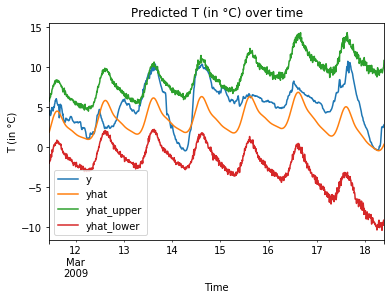

In [ ]:
pd.plotting.register_matplotlib_converters()  # needed to plot timestamps
forecast[-n_periods:].plot(x='ds', y=['y', 'yhat', 'yhat_upper', 'yhat_lower'])
plt.title('Predicted T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

Outlier scores and predictions:

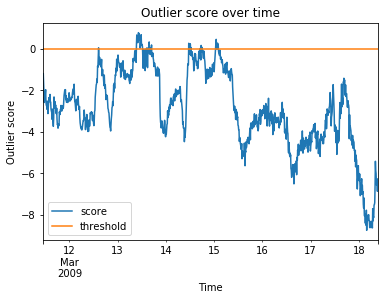

In [ ]:
od_preds['data']['forecast']['threshold'] = np.zeros(n_periods)
od_preds['data']['forecast'][-n_periods:].plot(x='ds', y=['score', 'threshold'])
plt.title('Outlier score over time')
plt.xlabel('Time')
plt.ylabel('Outlier score')
plt.show()

The outlier scores naturally trend down as uncertainty increases when we predict further in the future.

Let's look at some individual outliers:

In [ ]:
df_fcst = od_preds['data']['forecast']
df_outlier = df_fcst.loc[df_fcst['score'] > 0]

In [ ]:
print('Number of outliers: {}'.format(df_outlier.shape[0]))
df_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']]

Number of outliers: 42


,ds,yhat,yhat_lower,yhat_upper,y
166,2009-03-12 14:30:00,5.826341,2.359631,9.523064,2.32
279,2009-03-13 09:20:00,2.438507,-1.834116,6.408030,6.60
280,2009-03-13 09:30:00,2.546610,-1.484339,6.560092,7.22
281,2009-03-13 09:40:00,2.661307,-1.238431,6.712489,7.11
282,2009-03-13 09:50:00,2.782348,-1.284963,6.631783,7.22
283,2009-03-13 10:00:00,2.909426,-1.360733,7.213170,7.50
284,2009-03-13 10:10:00,3.042175,-0.938601,7.138561,7.71
285,2009-03-13 10:20:00,3.180168,-0.542519,7.159230,7.93
286,2009-03-13 10:30:00,3.322914,-0.749686,7.319972,7.98
287,2009-03-13 10:40:00,3.469862,-0.639899,7.248605,7.97
